In [2]:
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from optuna import Trial
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

2024-02-18 20:07:00.779838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:07:00.779958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:07:00.918916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv').drop(columns=['id'])
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv').drop(columns=['id'])

In [5]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
train.shape

(20758, 17)

In [7]:
train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [8]:
# Adding additional data on which the playground data was developed
df = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [9]:
df.shape

(2111, 17)

In [10]:
df.isnull().sum()
# No missings means we don't need to worry about imputation and can just append the datasets

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [11]:
train = pd.concat([train, df])

# Basic EDA

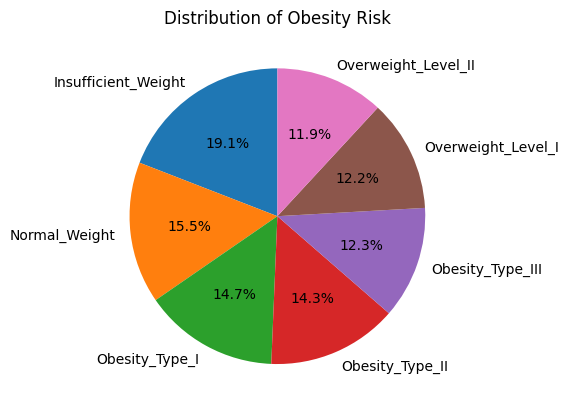

In [12]:
plt.pie(train['NObeyesdad'].value_counts().values, labels=np.unique(train['NObeyesdad']), autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Obesity Risk')
plt.show()
# unbalanced multi class classification so will need to stratify during any modelling.

In [13]:
numeric_columns = train.select_dtypes(include='number').columns.tolist()
categorical_columns = train.select_dtypes(include='object').columns.tolist()
categorical_columns.remove('NObeyesdad')

In [14]:
def plot_numeric_distributions(df, numeric_columns, target_variable):

    # Determine the number of subplots required
    num_numeric_columns = len(numeric_columns)
    num_subplots = math.ceil(num_numeric_columns / 2)

    # Create subplots
    fig, axes = plt.subplots(num_subplots, 2, figsize=(8, 4 * num_subplots))
    axes = axes.flatten()

    # Plot distribution plots for each numeric column
    for i in range(num_numeric_columns):
        sns.histplot(data=df, x=numeric_columns[i], hue=target_variable, stat='percent', common_norm=False, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {numeric_columns[i]}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

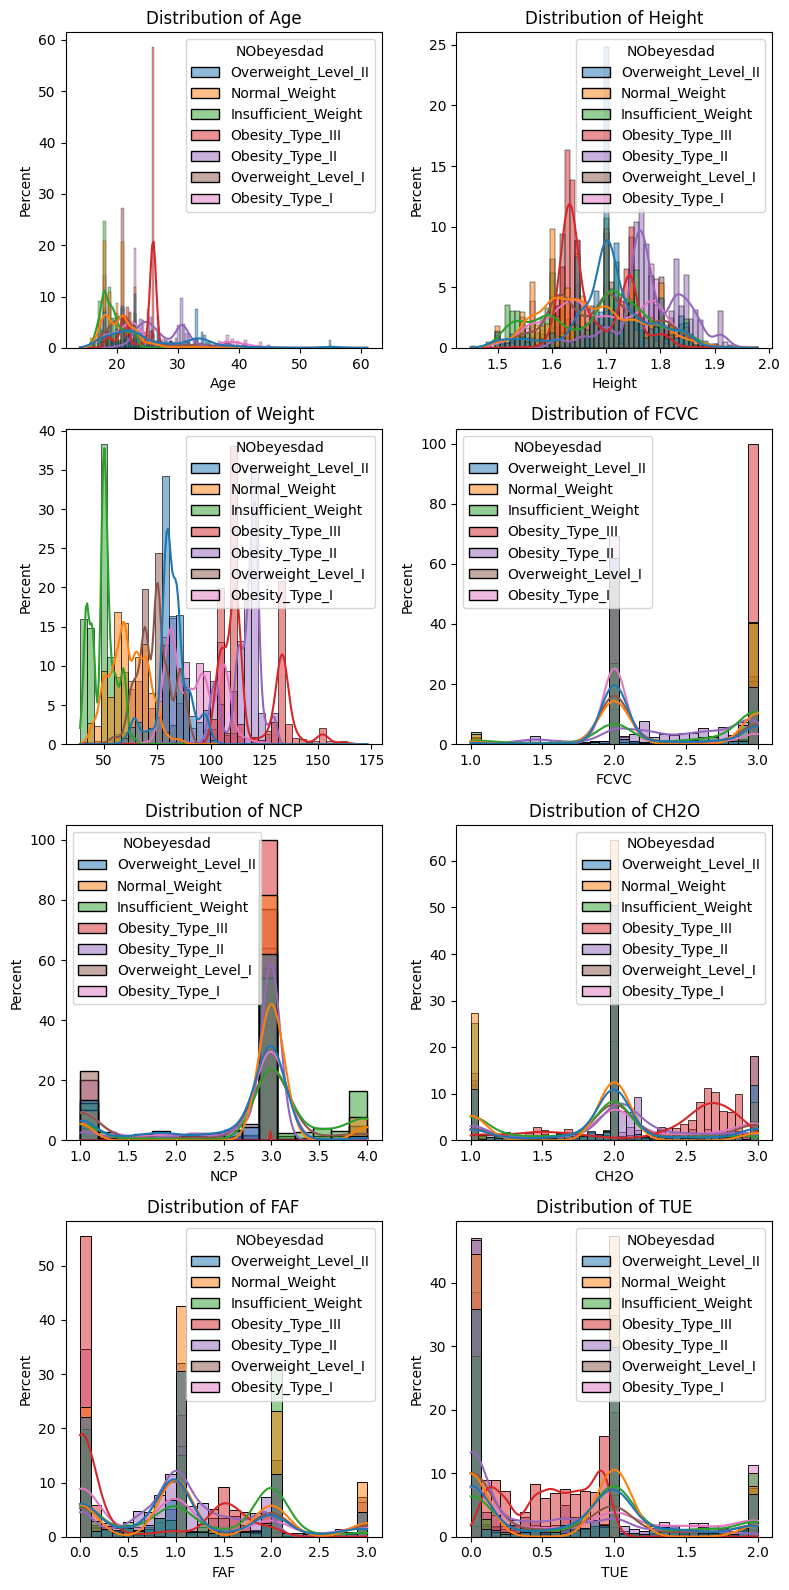

In [15]:
plot_numeric_distributions(train, numeric_columns, 'NObeyesdad')

In [16]:
# Now look at categorical variables
def plot_categorical_distributions(df, categorical_columns, target_variable):

    # Determine the number of subplots required
    num_categorical_columns = len(categorical_columns)
    num_subplots = math.ceil(num_categorical_columns / 2)

    # Create subplots
    fig, axes = plt.subplots(num_subplots, 2, figsize=(12, 4 * num_subplots))
    axes = axes.flatten()

    # Plot bar plots for categorical columns
    for i in range(num_categorical_columns):
        sns.countplot(data=df, x=categorical_columns[i], hue=target_variable, ax=axes[i])
        axes[i].set_title(f'Distribution of {categorical_columns[i]}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

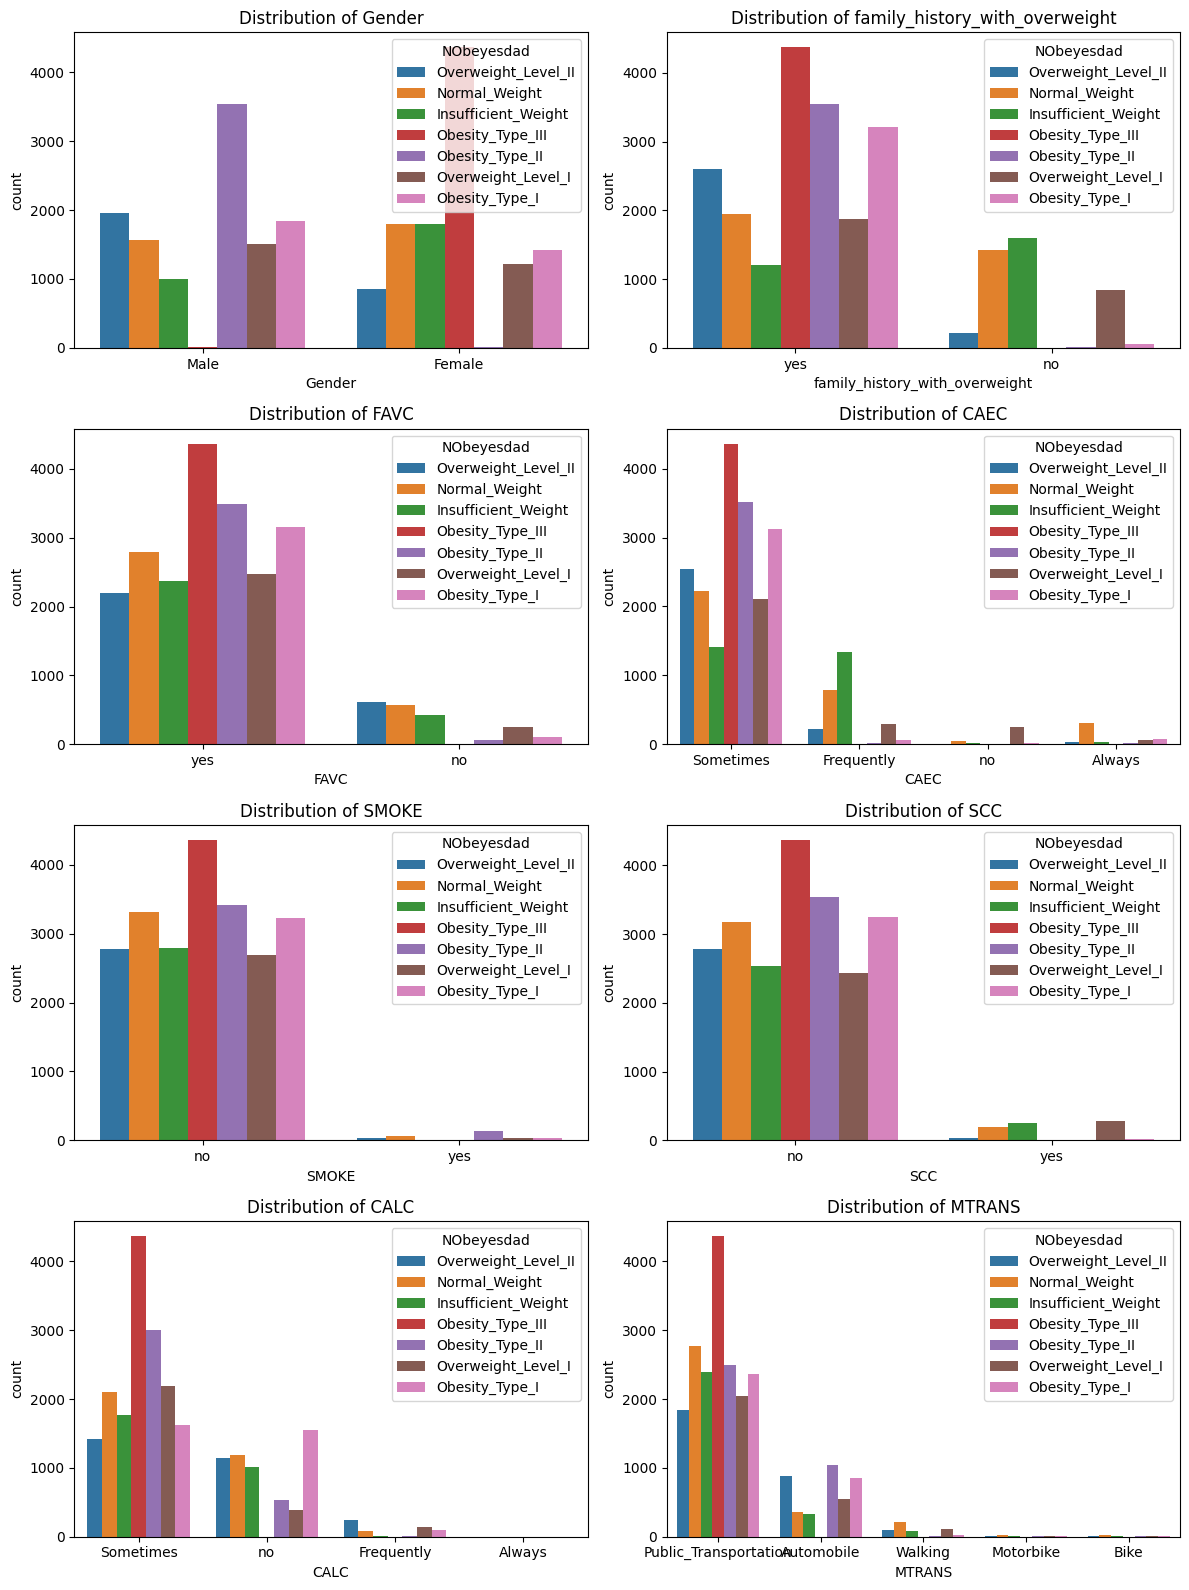

In [17]:
plot_categorical_distributions(train, categorical_columns,  'NObeyesdad')

Text(95.72222222222221, 0.5, 'Variables')

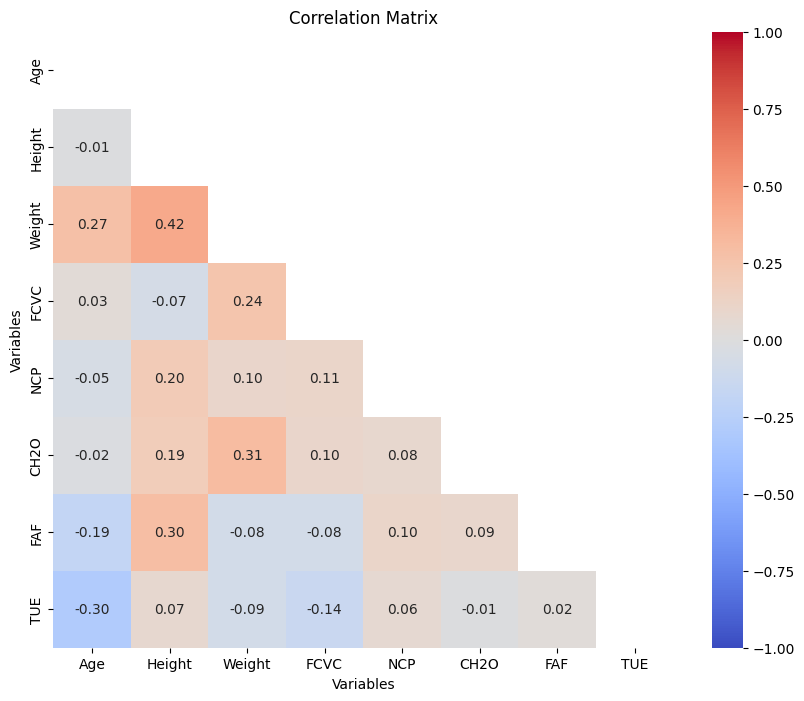

In [18]:
# Correlation analysis
# Compute the correlation matrix
corr_matrix = train.loc[:, numeric_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, vmin=-1, vmax=1)

# Customize plot labels and title
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')

## Observations:
* Weight appears to be in kilos so can create BMI directly from this. Height is also in meters so again can be used directly.
* No discrete variables being treated as numeric.

# Feature Engineering

In [19]:
# Encode categorical variables
# Fit this based on values present in both train and test data
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(pd.concat([train[categorical_columns], test[categorical_columns]], axis=0))

# Apply encoder to train
train_encoded = encoder.transform(train[categorical_columns])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# And to test
test_encoded = encoder.fit_transform(test[categorical_columns])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

In [20]:
train_sum = train_encoded_df.sum(axis=0).astype(int)
test_sum = test_encoded_df.sum(axis=0).astype(int)

sum_df = pd.concat([train_sum, test_sum], axis=1, keys=['Train', 'Test'])
sum_df

,Train,Test
Gender_Female,11465,6965
Gender_Male,11404,6875
family_history_with_overweight_no,4129,2456
family_history_with_overweight_yes,18740,11384
FAVC_no,2021,1257
FAVC_yes,20848,12583
CAEC_Always,531,359
CAEC_Frequently,2714,1617
CAEC_Sometimes,19294,11689
CAEC_no,330,175


In [21]:
# Treating CALC and CAEC as ordinal
levels = {"Always": 3, "Frequently": 2, "Sometimes": 1, "no": 0}
train["CALC_ord"] = train["CALC"].map(levels)
test["CALC_ord"] = test["CALC"].map(levels)
train["CAEC_ord"] = train["CAEC"].map(levels)
test["CAEC_ord"] = test["CAEC"].map(levels)

In [22]:
train_encoded_df.shape

(22869, 23)

In [23]:
train.drop(categorical_columns, axis=1).shape

(22869, 11)

In [24]:
train_encoded_df.reset_index(drop=True, inplace=True)
test_encoded_df.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train = pd.concat([train.drop(categorical_columns, axis=1), train_encoded_df], axis=1)
test = pd.concat([test.drop(categorical_columns, axis=1), test_encoded_df], axis=1)

In [25]:
# Create BMI
train['BMI'] = train['Weight'] / train['Height']**2
test['BMI'] = test['Weight'] / test['Height']**2

# Create water intake
train['Water_Intake_Per_Kg'] = train['CH2O'] / train['Weight']  
test['Water_Intake_Per_Kg'] = test['CH2O'] / test['Weight']  

In [26]:
# Get balance between exercise and using technology devices (assuming they arent exercising while doing this)
train['Physical_Activity_Level'] = train['FAF'] - train['TUE']
test['Physical_Activity_Level'] = test['FAF'] - test['TUE']

In [27]:
# Interaction between 'FCVC' (Frequency of consumption of vegetables) and 'NCP' (Number of main meals)
# to get meal habits
train['Meal_Habits'] = train['FCVC'] * train['NCP']
test['Meal_Habits'] = test['FCVC'] * test['NCP']

In [28]:
# Create technology usage score to determine relationship between age and tech usage
train['Tech_Usage_Score'] = train['TUE'] / train['Age']
test['Tech_Usage_Score'] = test['TUE'] / test['Age']

In [29]:
# Interaction between 'FCVC' (Frequency of consumption of vegetables) and 'FAVC' (Frequent consumption of high caloric food) 
train['Healthy_Nutrition_Habits'] = train['FCVC'] / ( 2 * train['FAVC_no'] - 1)
test['Healthy_Nutrition_Habits'] = test['FCVC'] / ( 2 * test['FAVC_no'] - 1)

In [30]:
unique_classes = np.unique(train['NObeyesdad'])

In [31]:
# Encode target variable
label_dict = {
    'Insufficient_Weight': 0, 
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3, 
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5, 
    'Obesity_Type_III': 6
}

inverse_label_dict = {label_dict[x]:x for x in label_dict.keys()}

train['NObeyesdad'] = train['NObeyesdad'].map(label_dict)

In [32]:
inverse_label_dict = {val:key for key, val in label_dict.items()}

In [33]:
X = train.loc[:, [col for col in train.columns if col != 'NObeyesdad']].values
y = train.loc[:, 'NObeyesdad'].values

In [34]:
# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

test = scaler.transform(test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, 
                                                    random_state=1890)

# Hyperparameter tuning of Deep Neural Network

In [36]:
# Function to create model based on hyperparameters
def create_model(num_layers, neurons, activations, dropout_rates, use_dropout):
    # Create and compile the model
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=X_train.shape[1], activation=activations[0]))
    
    if use_dropout[0]:
        model.add(Dropout(dropout_rates[0]))

    # Add additional hidden layers based on num_layers
    for i in range(1, num_layers): 
        model.add(Dense(neurons[i], activation=activations[i]))
        if use_dropout[i]:
            model.add(Dropout(dropout_rates[i]))

    model.add(Dense(unique_classes.shape[0], activation='softmax'))

    return model

In [37]:
# Dictionary of activation functions for Optuna
activation_functions = {'relu': 'relu',
                        'tanh': 'tanh',
                       'sigmoid':'sigmoid',
                       'leakyrelu':LeakyReLU()}

In [38]:
def objective(trial):
    # Define the search spaces for hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 5)
    activation = [trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'sigmoid', 'leakyrelu']) for i in range(num_layers)]
    dropout_rates = [trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.5) for i in range(num_layers)]
    use_dropout = [trial.suggest_categorical(f'use_dropout_{i}', [True, False]) for i in range(num_layers)]
    n_epochs = trial.suggest_int('n_epochs', 10, 50)
    neurons = [2 ** trial.suggest_int(f'neurons_{i}', 4, 10) for i in range(num_layers)]
    lr = trial.suggest_float('lr', 0.0001, 0.1)
    batch_size = trial.suggest_int('batch_size', 5, 10)
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_accuracies = []
    
    activations = [activation_functions[active] for active in activation]
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index,:], X_train[val_index, :]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create and compile the model
        model = create_model(num_layers, neurons, activations, dropout_rates, use_dropout)
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=2**batch_size, verbose=0)

        # Evaluate the model on the validation fold
        score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_accuracies.append(score[1])

    avg_val_accuracy = np.mean(val_accuracies)

    return avg_val_accuracy

# Set seed
tf.random.set_seed(42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=175)

[I 2024-02-18 20:07:30,159] A new study created in memory with name: no-name-43ef6b07-ef9a-43a3-be20-f51b1537463e
I0000 00:00:1708286853.745088      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[I 2024-02-18 20:10:22,038] Trial 0 finished with value: 0.5291170477867126 and parameters: {'num_layers': 5, 'activation_0': 'relu', 'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'relu', 'dropout_rate_0': 0.3079171372734185, 'dropout_rate_1': 0.1890123690045648, 'dropout_rate_2': 0.4662379835596859, 'dropout_rate_3': 0.08334390335982811, 'dropout_rate_4': 0.25299260630542453, 'use_dropout_0': False, 'use_dropout_1': False, 'use_dropout_2': True, 'use_dropout_3': True, 'use_dropout_4': False, 'n_epochs': 45, 'neurons_0': 7, 'neurons_1': 7, 'neurons_2': 6, 'neurons_3': 6, 'neurons_4': 7, 'lr': 0.025882318777311453, 'batch_size': 6}. Best is trial 0 with value: 0.529117047786

In [39]:
print(study.best_params)

{'num_layers': 2, 'activation_0': 'relu', 'activation_1': 'sigmoid', 'dropout_rate_0': 0.405740994497683, 'dropout_rate_1': 0.08057548976558788, 'use_dropout_0': True, 'use_dropout_1': False, 'n_epochs': 42, 'neurons_0': 8, 'neurons_1': 5, 'lr': 0.005480109754545876, 'batch_size': 10}


In [40]:
num_layers = study.best_params['num_layers']
dropout_rates = []
neurons = []
use_dropout = []
activations = []

for key, val in study.best_params.items():
    if 'dropout_rate' in key:
        dropout_rates.append(val)
    if 'use_dropout' in key:
        use_dropout.append(val)
    if 'neurons' in key:
        neurons.append(2**val)
    if 'activation' in key:
        activations.append(activation_functions[val])

# Train Model Based on Optimal Parameters

In [41]:
model = create_model(num_layers, neurons, activations, dropout_rates, use_dropout)

In [42]:
model.summary()

Model: "sequential_875"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2870 (Dense)          (None, 256)               10240     
                                                                 
 dropout_1150 (Dropout)      (None, 256)               0         
                                                                 
 dense_2871 (Dense)          (None, 32)                8224      
                                                                 
 dense_2872 (Dense)          (None, 7)                 231       
                                                                 
Total params: 18695 (73.03 KB)
Trainable params: 18695 (73.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=study.best_params['lr']),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=study.best_params['n_epochs'], batch_size=2**study.best_params['batch_size'], 
                   validation_data=(X_test, y_test))

Epoch 1/42
19/19 [==============================] - 1s 12ms/step - loss: 1.3726 - accuracy: 0.5118 - val_loss: 0.9460 - val_accuracy: 0.6677
Epoch 2/42
19/19 [==============================] - 0s 4ms/step - loss: 0.8516 - accuracy: 0.6935 - val_loss: 0.7103 - val_accuracy: 0.7458
Epoch 3/42
19/19 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.7645 - val_loss: 0.5583 - val_accuracy: 0.8088
Epoch 4/42
19/19 [==============================] - 0s 4ms/step - loss: 0.5564 - accuracy: 0.8105 - val_loss: 0.4661 - val_accuracy: 0.8493
Epoch 5/42
19/19 [==============================] - 0s 4ms/step - loss: 0.4824 - accuracy: 0.8337 - val_loss: 0.4171 - val_accuracy: 0.8633
Epoch 6/42
19/19 [==============================] - 0s 4ms/step - loss: 0.4422 - accuracy: 0.8458 - val_loss: 0.3872 - val_accuracy: 0.8729
Epoch 7/42
19/19 [==============================] - 0s 4ms/step - loss: 0.4146 - accuracy: 0.8539 - val_loss: 0.3713 - val_accuracy: 0.8782
Epoch 8/42
19/19 [=

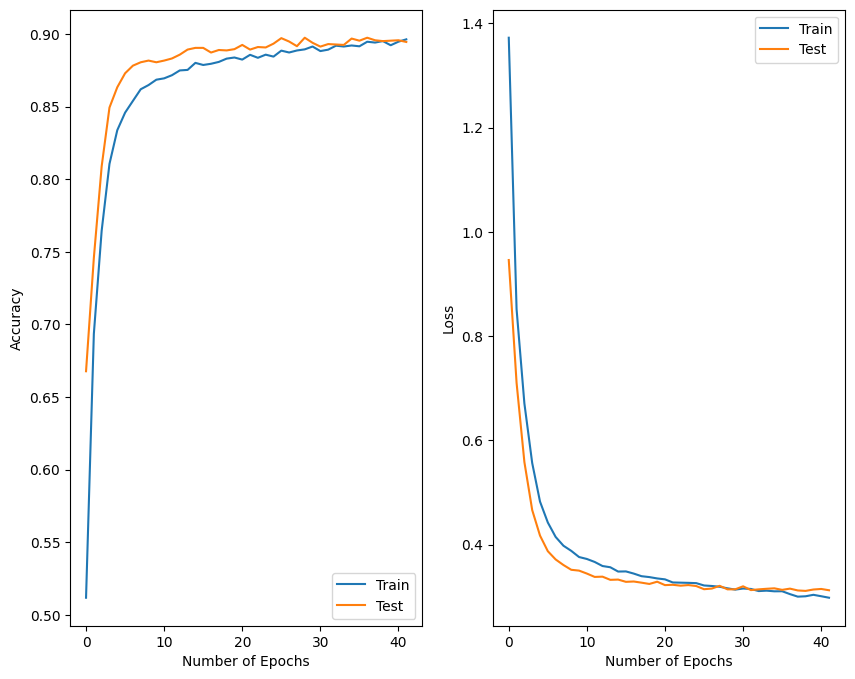

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8))

sns.lineplot(history.history['loss'],ax=ax[1], label='Train')
sns.lineplot(history.history['val_loss'],ax=ax[1], label='Test')

ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Loss')

sns.lineplot(history.history['accuracy'],ax=ax[0], label='Train')
sns.lineplot(history.history['val_accuracy'],ax=ax[0], label='Test')

ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].legend()

# Confusion Matrix

108/108 [==============================] - 0s 1ms/step


Text(50.722222222222214, 0.5, 'Predicted Label')

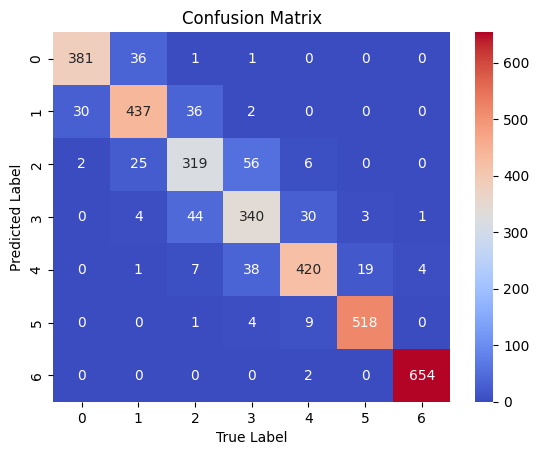

In [45]:
preds = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test, preds)
hm = sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm")
hm.set_title('Confusion Matrix')

hm.set_xlabel('True Label')
hm.set_ylabel('Predicted Label')